## Adam convergence problem

In [52]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Synthetic example 1: online learning

We will solve the online optimization problem for function  $f_t(x) = \begin{cases} 1010x, \text{for t mod 101} = 1 \\ 
-10x, otherwise \end{cases}$

Online optimization task: $ F(x) = \sum_t f_t(x)  \to min_x$

with the constraint set $\mathcal{F} =[-1, 1]$

The analitical solution for this task is $x^*=-1$

In order to understand the problems of Adam, we denote the concept of "regret": $R_T = \sum\limits_{t=1}^T f_t(x_t) - \min\limits_{x \in \mathcal{F}} \sum\limits_{t=1}^T f_t(x)$

The regret should tend to zero during optimization, it implies that on average,
the model’s performance converges to the optimal one.

In [2]:
loss_buffer = []

In [3]:
import adashift.optimizers as ad_opt

In [4]:
def online_f_t(x, t):
    if t % 101 == 1:
        return 1010.0*x
    else:
        return -10.0*x
    
def f_min(t):
    if t % 101 == 1:
        return -1010.0
    else:
        return 10.0

In [5]:
def OnlineLearning(optimizer_type='Adam', alpha=1, lr_decay=True, eps=0.,
                   x_init=0.0, betas=(0.9, 0.99), amsgrad=False, max_step = 1000001):
    x = torch.tensor([x_init], requires_grad=True)
    lr = alpha
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], amsgrad=amsgrad, lr=lr, betas=betas, eps=eps)
    else:
        optimizer = ad_opt.AdaShift([x], lr=lr, betas=betas, eps=eps)
    
    
    regret_sum = 0
    time_steps = []
    avg_regret_history = []
    x_history = []
    
    if lr_decay:
        lambda_lr_decay = lambda step: alpha / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    for step in range(1, max_step):
        # constraint
        x.data = x.data.clamp(-1, 1)
        
        loss = online_f_t(x, step)

        regret_sum += (loss.item() - f_min(step))
        regret_avg = regret_sum / step
    
        loss.backward()
        
        x_history.append(x.item())

        if step % 10000 == 0:
            time_steps.append(step)
            avg_regret_history.append(regret_avg)
        if step % 50000 == 0:
            print('step : {} loss: {} regret_avg : {} x: {}'.format(step, loss.item() , regret_avg, x.item()))

        optimizer.step()
                                
        if lr_decay:
            scheduler.step()
        optimizer.zero_grad()
                                                      
    return time_steps, avg_regret_history, x_history

In [6]:
time_steps, avg_regret_history, x_history = OnlineLearning()

step : 50000 loss: -9.889703750610352 regret_avg : 0.5064160437881574 x: 0.9889703989028931
step : 100000 loss: -9.864534378051758 regret_avg : 0.4067958796649985 x: 0.9864534735679626
step : 150000 loss: -9.865385055541992 regret_avg : 0.36496171242752423 x: 0.9865384697914124
step : 200000 loss: -9.87474250793457 regret_avg : 0.34069642169266007 x: 0.9874742031097412
step : 250000 loss: -9.886850357055664 regret_avg : 0.32442571966003625 x: 0.9886850118637085
step : 300000 loss: -9.899446487426758 regret_avg : 0.3125654876726804 x: 0.9899446368217468
step : 350000 loss: -9.911629676818848 regret_avg : 0.3034359073735933 x: 0.9911629557609558
step : 400000 loss: -9.92305850982666 regret_avg : 0.2961329248513235 x: 0.9923058152198792
step : 450000 loss: -9.933679580688477 regret_avg : 0.29012170080303734 x: 0.9933679699897766
step : 500000 loss: -9.943526268005371 regret_avg : 0.2850632473994456 x: 0.9943526387214661
step : 550000 loss: -9.952676773071289 regret_avg : 0.280731002208641

In [7]:
amsgrad_time_steps, amsgrad_avg_regret_history, amsgrad_x_history = OnlineLearning(amsgrad=True)

step : 50000 loss: 9.866371154785156 regret_avg : 0.31438381194114684 x: -0.9866371154785156
step : 100000 loss: 9.961386680603027 regret_avg : 0.21818181499004363 x: -0.9961386919021606
step : 150000 loss: 9.991243362426758 regret_avg : 0.17665848134676615 x: -0.9991243481636047
step : 200000 loss: 10.0 regret_avg : 0.1522245525431633 x: -1.0
step : 250000 loss: 9.999848365783691 regret_avg : 0.13568643005943298 x: -0.999984860420227
step : 300000 loss: 9.997462272644043 regret_avg : 0.12354937993208567 x: -0.9997462034225464
step : 350000 loss: 9.993610382080078 regret_avg : 0.11415799653870719 x: -0.9993610382080078
step : 400000 loss: 9.989237785339355 regret_avg : 0.10661422948002815 x: -0.9989237785339355
step : 450000 loss: 9.984785079956055 regret_avg : 0.10038345542165968 x: -0.9984785318374634
step : 500000 loss: 9.980443954467773 regret_avg : 0.09512501832294463 x: -0.9980443716049194
step : 550000 loss: 9.976297378540039 regret_avg : 0.09061027578093789 x: -0.99762970209121

In [8]:
adashift_time_steps, adashift_avg_regret_history, adashift_x_history = OnlineLearning(optimizer_type='Adashift') 

step : 50000 loss: 9.873220443725586 regret_avg : 0.463386503688395 x: -0.9873220324516296
step : 100000 loss: 10.0 regret_avg : 0.3262722123773396 x: -1.0
step : 150000 loss: 9.991798400878906 regret_avg : 0.26590045690268277 x: -0.9991798400878906
step : 200000 loss: 9.98381519317627 regret_avg : 0.23001920878209173 x: -0.9983815550804138
step : 250000 loss: 9.977197647094727 regret_avg : 0.20557853314048052 x: -0.9977197647094727
step : 300000 loss: 9.971391677856445 regret_avg : 0.1875609749462704 x: -0.9971391558647156
step : 350000 loss: 9.966115951538086 regret_avg : 0.1735716709588681 x: -0.9966115951538086
step : 400000 loss: 9.961211204528809 regret_avg : 0.1623040677298978 x: -0.9961211085319519
step : 450000 loss: 9.956570625305176 regret_avg : 0.15297691489872006 x: -0.9956570863723755
step : 500000 loss: 9.952126502990723 regret_avg : 0.1450906378223002 x: -0.9952126741409302
step : 550000 loss: 9.947837829589844 regret_avg : 0.1383089264480905 x: -0.9947838187217712
step

Regret should tend to zero. As we can see it is done only for amsgrad.

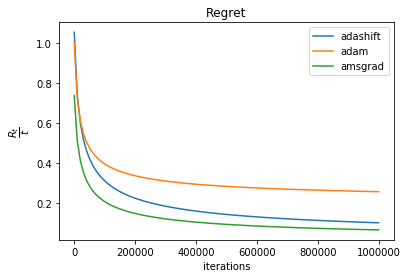

In [9]:
plt.title("Regret")
plt.plot(np.linspace(1, 1000001, 100), adashift_avg_regret_history, label='adashift')
plt.plot(np.linspace(1, 1000001, 100), avg_regret_history,label='adam')
plt.plot(np.linspace(1, 1000001, 100), amsgrad_avg_regret_history,label='amsgrad')
plt.xlabel("iterations")
plt.ylabel(r"$\dfrac{R_t}{t}$")
plt.legend()
plt.show()

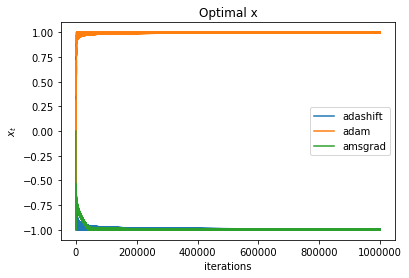

In [10]:
plt.title("Optimal x")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(amsgrad_x_history,label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

# Synthetic example 2: stochastic case

Let's see on the similar task, but with stochasticity.

$\delta = 0.002$
C = 101

$f_t(x) = \begin{cases} Cx, \text{with p } =\frac{1+\delta}{C+1} \\ 
-x, otherwise \end{cases}$

Cost function is $\delta x$

In [6]:
delta = 0.02
C = 101
p = (1+delta)/(C + 1)

def stoch_f_t(x, t):
    if np.random.binomial(1,p):
        return C*x
    else:
        return -x

In [7]:
def StochLearning(optimizer_type='Adam', alpha=1e-3, lr_decay=True,\
                  eps=1e-10, betas=(0.0, 0.999), amsgrad=False, max_step = 1000001):
    
    x = torch.tensor([0.0], requires_grad=True)
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], lr=alpha, betas=betas, eps=eps, amsgrad=amsgrad)
    else:
        optimizer = ad_opt.AdaShift([x], lr=alpha, keep_num=1, betas=betas, eps=eps)

    time_steps = []
    avg_regret_history = []
    x_history = []
    loss_history = []
    print("Optimization with {}".format(optimizer_type))
    
    if lr_decay:
        lambda_lr_decay = lambda step: alpha / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    for step in range(1, max_step):
        #x.data = x.data.clamp(-1.0, 1.0)

        loss = stoch_f_t(x, step)

        loss.backward()
        if step % 10000 == 0:
            x_history.append(x.item())
            loss_history.append(loss.item())
            time_steps.append(step)

        if step % 100000 == 0:
            print ('step : ', step, '  loss : ', loss.item(), ' x:', x.item())
                                 
        optimizer.step()   

        if lr_decay:
            scheduler.step()
        
        optimizer.zero_grad()
            
    return time_steps, loss_history, x_history

In [17]:
lr = 1e-3
time_steps, loss_history, x_history = StochLearning(alpha=lr, lr_decay=False, max_step=10000000)

Optimization with Adam
step :  100000   loss :  0.024470333009958267  x: -0.024470333009958267
step :  200000   loss :  0.2543334662914276  x: -0.2543334662914276
step :  300000   loss :  0.138028085231781  x: -0.138028085231781
step :  400000   loss :  0.194101020693779  x: -0.194101020693779
step :  500000   loss :  -0.19227567315101624  x: 0.19227567315101624
step :  600000   loss :  -0.9761835932731628  x: 0.9761835932731628
step :  700000   loss :  -1.8436503410339355  x: 1.8436503410339355
step :  800000   loss :  -1.9853883981704712  x: 1.9853883981704712
step :  900000   loss :  -2.1280596256256104  x: 2.1280596256256104
step :  1000000   loss :  -2.507331371307373  x: 2.507331371307373
step :  1100000   loss :  -2.4876019954681396  x: 2.4876019954681396
step :  1200000   loss :  -2.6244866847991943  x: 2.6244866847991943
step :  1300000   loss :  -2.7622299194335938  x: 2.7622299194335938
step :  1400000   loss :  -3.1374475955963135  x: 3.1374475955963135
step :  1500000   lo

In [20]:
adashift_time_steps, adashift_loss_history, adashift_x_history = \
                    StochLearning(optimizer_type='Adashift',lr_decay=False, max_step=10000000)

Optimization with Adashift
step :  100000   loss :  0.17434974014759064  x: -0.17434974014759064
step :  200000   loss :  0.40415313839912415  x: -0.40415313839912415
step :  300000   loss :  0.578467845916748  x: -0.578467845916748
step :  400000   loss :  1.0358682870864868  x: -1.0358682870864868
step :  500000   loss :  1.4750570058822632  x: -1.4750570058822632
step :  600000   loss :  1.544525146484375  x: -1.544525146484375
step :  700000   loss :  2.1435563564300537  x: -2.1435563564300537
step :  800000   loss :  2.045781135559082  x: -2.045781135559082
step :  900000   loss :  2.115391731262207  x: -2.115391731262207
step :  1000000   loss :  2.049607753753662  x: -2.049607753753662
step :  1100000   loss :  2.481123447418213  x: -2.481123447418213
step :  1200000   loss :  3.142401933670044  x: -3.142401933670044
step :  1300000   loss :  3.6849310398101807  x: -3.6849310398101807
step :  1400000   loss :  4.084707260131836  x: -4.084707260131836
step :  1500000   loss :  4.

In [21]:
ams_time_steps, ams_loss_history, ams_x_history = StochLearning(alpha=lr, amsgrad=True, 
                                                                lr_decay=False, max_step=10000000)

Optimization with Adam
step :  100000   loss :  0.054892994463443756  x: -0.054892994463443756
step :  200000   loss :  0.5457460880279541  x: -0.5457460880279541
step :  300000   loss :  0.6191473603248596  x: -0.6191473603248596
step :  400000   loss :  0.316234290599823  x: -0.316234290599823
step :  500000   loss :  0.2916260063648224  x: -0.2916260063648224
step :  600000   loss :  0.16864553093910217  x: -0.16864553093910217
step :  700000   loss :  0.18000690639019012  x: -0.18000690639019012
step :  800000   loss :  0.9851465225219727  x: -0.9851465225219727
step :  900000   loss :  1.0865345001220703  x: -1.0865345001220703
step :  1000000   loss :  1.2040914297103882  x: -1.2040914297103882
step :  1100000   loss :  1.7001928091049194  x: -1.7001928091049194
step :  1200000   loss :  1.723340630531311  x: -1.723340630531311
step :  1300000   loss :  1.7533031702041626  x: -1.7533031702041626
step :  1400000   loss :  1.5515652894973755  x: -1.5515652894973755
step :  1500000 

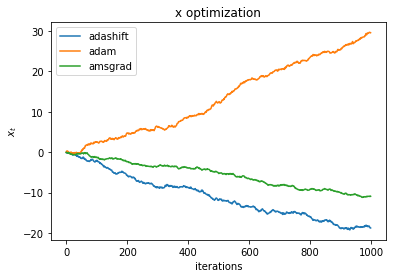

In [22]:
plt.title("x optimization")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(ams_x_history, label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

# MNIST experiments

### Logistic regression

In [4]:
import torch
from torch import nn

In [5]:
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional as F

input_size = 784
num_classes = 10
num_epochs = 200
batch_size = 64

train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           download=True,
                                           transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))]))

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [7]:
import torch.nn as nn

device = torch.device('cuda')

model = nn.Linear(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()

In [17]:
def train(model, device, train_loader, optimizer, num_epochs, criterion, display_iter=1000):
    model.train()
    train_loss_hist = []
    test_acc_hist = []
    test_loss_hist = []
    
    test_loss, test_acc = test(model, device, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)
    
    for epoch in range(num_epochs):  
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.reshape(-1, 28*28))
            loss = criterion(output, target)
            train_loss_hist.append(loss.item())
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                test_loss, test_acc = test(model, device, test_loader, criterion)
                test_loss_hist.append(test_loss)
                test_acc_hist.append(test_acc)

            if batch_idx % display_iter == 0:
                print('Train Epoch: {} TrainLoss: {:.6f}'.format(
                    epoch, loss.item()))

                print('Test set:       TestLoss:  {:.4f}, Accuracy: {:.0f}%'.format(
                    test_loss_hist[-1], test_acc_hist[-1]))

    return train_loss_hist, test_loss_hist, test_acc_hist

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.reshape(-1, 28*28))
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc

Optimizing with Adam

In [97]:
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0)

adam_train_loss_hist, adam_test_loss_hist, adam_test_acc_hist = \
                            train(model, device, train_loader, adam_optimizer, 200, criterion)                

Train Epoch: 0 TrainLoss: 2.402474
Test set:       TestLoss:  0.0336, Accuracy: 21%
Train Epoch: 1 TrainLoss: 0.311013
Test set:       TestLoss:  0.0048, Accuracy: 91%
Train Epoch: 2 TrainLoss: 0.318628
Test set:       TestLoss:  0.0044, Accuracy: 92%
Train Epoch: 3 TrainLoss: 0.219145
Test set:       TestLoss:  0.0045, Accuracy: 92%
Train Epoch: 4 TrainLoss: 0.340785
Test set:       TestLoss:  0.0042, Accuracy: 92%
Train Epoch: 5 TrainLoss: 0.528127
Test set:       TestLoss:  0.0043, Accuracy: 92%
Train Epoch: 6 TrainLoss: 0.217013
Test set:       TestLoss:  0.0043, Accuracy: 92%
Train Epoch: 7 TrainLoss: 0.251285
Test set:       TestLoss:  0.0045, Accuracy: 92%
Train Epoch: 8 TrainLoss: 0.449693
Test set:       TestLoss:  0.0045, Accuracy: 92%
Train Epoch: 9 TrainLoss: 0.191217
Test set:       TestLoss:  0.0044, Accuracy: 92%
Train Epoch: 10 TrainLoss: 0.133005
Test set:       TestLoss:  0.0048, Accuracy: 91%
Train Epoch: 11 TrainLoss: 0.178675
Test set:       TestLoss:  0.0045, Accu

Train Epoch: 97 TrainLoss: 0.329810
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 98 TrainLoss: 0.132340
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 99 TrainLoss: 0.468833
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 100 TrainLoss: 0.287997
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 101 TrainLoss: 0.304157
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 102 TrainLoss: 0.225034
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 103 TrainLoss: 0.122446
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 104 TrainLoss: 0.321124
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 105 TrainLoss: 0.269978
Test set:       TestLoss:  0.0049, Accuracy: 92%
Train Epoch: 106 TrainLoss: 0.282371
Test set:       TestLoss:  0.0050, Accuracy: 92%
Train Epoch: 107 TrainLoss: 0.061612
Test set:       TestLoss:  0.0049, Accuracy: 92%
Train Epoch: 108 TrainLoss: 0.504144
Test set:       Test

Train Epoch: 193 TrainLoss: 0.142323
Test set:       TestLoss:  0.0051, Accuracy: 92%
Train Epoch: 194 TrainLoss: 0.269816
Test set:       TestLoss:  0.0050, Accuracy: 92%
Train Epoch: 195 TrainLoss: 0.293022
Test set:       TestLoss:  0.0050, Accuracy: 92%
Train Epoch: 196 TrainLoss: 0.444980
Test set:       TestLoss:  0.0049, Accuracy: 92%
Train Epoch: 197 TrainLoss: 0.287096
Test set:       TestLoss:  0.0049, Accuracy: 92%
Train Epoch: 198 TrainLoss: 0.524168
Test set:       TestLoss:  0.0050, Accuracy: 92%
Train Epoch: 199 TrainLoss: 0.210190
Test set:       TestLoss:  0.0050, Accuracy: 92%


Optimizing with AMSGrad

In [98]:
model = nn.Linear(input_size, num_classes).cuda()

amsgrad_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0,amsgrad=True)

amsgrad_train_loss_hist, amsgrad_test_loss_hist, amsgrad_test_acc_hist = \
                            train(model, device, train_loader, amsgrad_optimizer, 200, criterion) 

Train Epoch: 0 TrainLoss: 2.715531
Test set:       TestLoss:  0.0370, Accuracy: 10%
Train Epoch: 1 TrainLoss: 0.259418
Test set:       TestLoss:  0.0046, Accuracy: 92%
Train Epoch: 2 TrainLoss: 0.133005
Test set:       TestLoss:  0.0045, Accuracy: 92%
Train Epoch: 3 TrainLoss: 0.178677
Test set:       TestLoss:  0.0043, Accuracy: 92%
Train Epoch: 4 TrainLoss: 0.241203
Test set:       TestLoss:  0.0045, Accuracy: 92%
Train Epoch: 5 TrainLoss: 0.359785
Test set:       TestLoss:  0.0043, Accuracy: 92%
Train Epoch: 6 TrainLoss: 0.372174
Test set:       TestLoss:  0.0046, Accuracy: 92%
Train Epoch: 7 TrainLoss: 0.338707
Test set:       TestLoss:  0.0043, Accuracy: 93%
Train Epoch: 8 TrainLoss: 0.315904
Test set:       TestLoss:  0.0045, Accuracy: 92%
Train Epoch: 9 TrainLoss: 0.157704
Test set:       TestLoss:  0.0044, Accuracy: 92%
Train Epoch: 10 TrainLoss: 0.141729
Test set:       TestLoss:  0.0043, Accuracy: 93%
Train Epoch: 11 TrainLoss: 0.156350
Test set:       TestLoss:  0.0043, Accu

Train Epoch: 97 TrainLoss: 0.402155
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 98 TrainLoss: 0.258318
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 99 TrainLoss: 0.053282
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 100 TrainLoss: 0.235550
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 101 TrainLoss: 0.327556
Test set:       TestLoss:  0.0049, Accuracy: 92%
Train Epoch: 102 TrainLoss: 0.189941
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 103 TrainLoss: 0.331602
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 104 TrainLoss: 0.521810
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 105 TrainLoss: 0.069220
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 106 TrainLoss: 0.143938
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 107 TrainLoss: 0.225466
Test set:       TestLoss:  0.0049, Accuracy: 92%
Train Epoch: 108 TrainLoss: 0.192131
Test set:       Test

Train Epoch: 193 TrainLoss: 0.159934
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 194 TrainLoss: 0.380665
Test set:       TestLoss:  0.0050, Accuracy: 92%
Train Epoch: 195 TrainLoss: 0.377661
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 196 TrainLoss: 0.173597
Test set:       TestLoss:  0.0049, Accuracy: 92%
Train Epoch: 197 TrainLoss: 0.152226
Test set:       TestLoss:  0.0051, Accuracy: 92%
Train Epoch: 198 TrainLoss: 0.106723
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 199 TrainLoss: 0.123306
Test set:       TestLoss:  0.0050, Accuracy: 92%


Optimizing with max-AdaShift

In [99]:
model = nn.Linear(input_size, num_classes).cuda()

adashift_optimizer = ad_opt.AdaShift(model.parameters(), lr=1e-2,\
                             betas=(0.0, 0.999), eps=1e-8)

adashift_train_loss_hist, adashift_test_loss_hist, adashift_test_acc_hist = \
                            train(model, device, train_loader, adashift_optimizer, 200, criterion) 

Train Epoch: 0 TrainLoss: 2.376153
Test set:       TestLoss:  0.0389, Accuracy: 11%
Train Epoch: 1 TrainLoss: 0.327534
Test set:       TestLoss:  0.0050, Accuracy: 91%
Train Epoch: 2 TrainLoss: 0.449610
Test set:       TestLoss:  0.0047, Accuracy: 91%
Train Epoch: 3 TrainLoss: 0.249742
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 4 TrainLoss: 0.331219
Test set:       TestLoss:  0.0049, Accuracy: 91%
Train Epoch: 5 TrainLoss: 0.107159
Test set:       TestLoss:  0.0049, Accuracy: 91%
Train Epoch: 6 TrainLoss: 0.241066
Test set:       TestLoss:  0.0045, Accuracy: 92%
Train Epoch: 7 TrainLoss: 0.588549
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 8 TrainLoss: 0.422006
Test set:       TestLoss:  0.0050, Accuracy: 91%
Train Epoch: 9 TrainLoss: 0.295606
Test set:       TestLoss:  0.0049, Accuracy: 91%
Train Epoch: 10 TrainLoss: 0.416576
Test set:       TestLoss:  0.0048, Accuracy: 91%
Train Epoch: 11 TrainLoss: 0.224465
Test set:       TestLoss:  0.0046, Accu

Train Epoch: 97 TrainLoss: 0.264718
Test set:       TestLoss:  0.0051, Accuracy: 92%
Train Epoch: 98 TrainLoss: 0.213273
Test set:       TestLoss:  0.0051, Accuracy: 92%
Train Epoch: 99 TrainLoss: 0.584422
Test set:       TestLoss:  0.0053, Accuracy: 91%
Train Epoch: 100 TrainLoss: 0.134256
Test set:       TestLoss:  0.0053, Accuracy: 91%
Train Epoch: 101 TrainLoss: 0.282989
Test set:       TestLoss:  0.0054, Accuracy: 91%
Train Epoch: 102 TrainLoss: 0.172635
Test set:       TestLoss:  0.0051, Accuracy: 92%
Train Epoch: 103 TrainLoss: 0.136275
Test set:       TestLoss:  0.0052, Accuracy: 92%
Train Epoch: 104 TrainLoss: 0.096432
Test set:       TestLoss:  0.0054, Accuracy: 91%
Train Epoch: 105 TrainLoss: 0.257308
Test set:       TestLoss:  0.0051, Accuracy: 92%
Train Epoch: 106 TrainLoss: 0.219089
Test set:       TestLoss:  0.0051, Accuracy: 92%
Train Epoch: 107 TrainLoss: 0.139443
Test set:       TestLoss:  0.0050, Accuracy: 92%
Train Epoch: 108 TrainLoss: 0.406064
Test set:       Test

Train Epoch: 193 TrainLoss: 0.233522
Test set:       TestLoss:  0.0052, Accuracy: 92%
Train Epoch: 194 TrainLoss: 0.446465
Test set:       TestLoss:  0.0052, Accuracy: 92%
Train Epoch: 195 TrainLoss: 0.221553
Test set:       TestLoss:  0.0058, Accuracy: 90%
Train Epoch: 196 TrainLoss: 0.197562
Test set:       TestLoss:  0.0053, Accuracy: 92%
Train Epoch: 197 TrainLoss: 0.269232
Test set:       TestLoss:  0.0052, Accuracy: 92%
Train Epoch: 198 TrainLoss: 0.302862
Test set:       TestLoss:  0.0060, Accuracy: 90%
Train Epoch: 199 TrainLoss: 0.371271
Test set:       TestLoss:  0.0060, Accuracy: 90%


Optimizing with non-AdaShift

In [ ]:
model = nn.Linear(input_size, num_classes).cuda()

non_adashift_optimizer = ad_opt.AdaShift(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, reduce_func=lambda x: x)

non_adashift_train_loss_hist, non_adashift_test_loss_hist, non_adashift_test_acc_hist = \
                            train(model, device, train_loader, non_adashift_optimizer, 200, criterion) 

Train Epoch: 0 TrainLoss: 2.280214
Test set:       TestLoss:  0.0364, Accuracy: 13%
Train Epoch: 1 TrainLoss: 0.495002
Test set:       TestLoss:  0.0046, Accuracy: 92%
Train Epoch: 2 TrainLoss: 0.173490
Test set:       TestLoss:  0.0044, Accuracy: 92%
Train Epoch: 3 TrainLoss: 0.321387
Test set:       TestLoss:  0.0044, Accuracy: 92%
Train Epoch: 4 TrainLoss: 0.183604
Test set:       TestLoss:  0.0043, Accuracy: 92%
Train Epoch: 5 TrainLoss: 0.230373
Test set:       TestLoss:  0.0044, Accuracy: 92%
Train Epoch: 6 TrainLoss: 0.273784
Test set:       TestLoss:  0.0045, Accuracy: 92%
Train Epoch: 7 TrainLoss: 0.131741
Test set:       TestLoss:  0.0046, Accuracy: 92%
Train Epoch: 8 TrainLoss: 0.200447
Test set:       TestLoss:  0.0043, Accuracy: 92%
Train Epoch: 9 TrainLoss: 0.071402
Test set:       TestLoss:  0.0043, Accuracy: 92%
Train Epoch: 10 TrainLoss: 0.528471
Test set:       TestLoss:  0.0045, Accuracy: 92%
Train Epoch: 11 TrainLoss: 0.327194
Test set:       TestLoss:  0.0044, Accu

Train Epoch: 97 TrainLoss: 0.276091
Test set:       TestLoss:  0.0052, Accuracy: 91%
Train Epoch: 98 TrainLoss: 0.570269
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 99 TrainLoss: 0.318627
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 100 TrainLoss: 0.275678
Test set:       TestLoss:  0.0051, Accuracy: 91%
Train Epoch: 101 TrainLoss: 0.168079
Test set:       TestLoss:  0.0049, Accuracy: 92%
Train Epoch: 102 TrainLoss: 0.252014
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 103 TrainLoss: 0.114286
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 104 TrainLoss: 0.350787
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 105 TrainLoss: 0.182344
Test set:       TestLoss:  0.0048, Accuracy: 92%
Train Epoch: 106 TrainLoss: 0.178741
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 107 TrainLoss: 0.118351
Test set:       TestLoss:  0.0047, Accuracy: 92%
Train Epoch: 108 TrainLoss: 0.216832
Test set:       Test

In [281]:
def save_as_npy(name, array):
    np_array = np.array([i for i in array]) 
    np.save('logs/log_reg/' + name, np_array)
    return np_array

In [124]:
adam_train_loss_hist = save_as_npy('adam_train_loss_hist', adam_train_loss_hist)
amsgrad_train_loss_hist = save_as_npy('amsgrad_train_loss_hist', amsgrad_train_loss_hist)
adashift_train_loss_hist = save_as_npy('adashift_train_loss_hist', adashift_train_loss_hist)
non_adashift_train_loss_hist = save_as_npy('non_adashift_train_loss_hist', non_adashift_train_loss_hist)

adam_test_loss_hist = save_as_npy('adam_test_loss_hist', adam_test_loss_hist)
amsgrad_test_loss_hist = save_as_npy('amsgrad_test_loss_hist', amsgrad_test_loss_hist)
adashift_test_loss_hist = save_as_npy('adashift_test_loss_hist', adashift_test_loss_hist)
non_adashift_test_loss_hist = save_as_npy('non_adashift_test_loss_hist', non_adashift_test_loss_hist)

adam_test_acc_hist = save_as_npy('adam_test_acc_hist', adam_test_acc_hist)
amsgrad_test_acc_hist = save_as_npy('amsgrad_test_acc_hist', amsgrad_test_acc_hist)
adashift_test_acc_hist = save_as_npy('adashift_test_acc_hist', adashift_test_acc_hist)
non_adashift_test_acc_hist = save_as_npy('non_adashift_test_acc_hist', non_adashift_test_acc_hist)

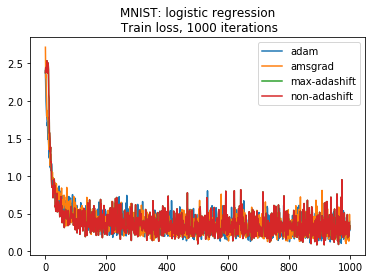

In [126]:
plt.title("MNIST: logistic regression\n Train loss, 1000 iterations")
#np.linspace(0, 1000000, 100),0
plt.plot(adam_train_loss_hist[:1000], label="adam")
plt.plot(amsgrad_train_loss_hist[:1000], label="amsgrad")
plt.plot(adashift_train_loss_hist[:1000], label="max-adashift")
plt.plot(adashift_train_loss_hist[:1000], label="non-adashift")

plt.legend(loc='best')
plt.show()

In [282]:
def smooth(y,box_size,smooth_start=0):
    # borrowed from authors code
    y_hat=np.zeros(y.shape,dtype=y.dtype)
    y_hat[0:smooth_start]=y[0:smooth_start]
    for i in range(smooth_start,y.size):
        if i < smooth_start+box_size//2:
            y_hat[i]=np.mean(y[smooth_start:i+box_size//2])
        elif i<y.size-box_size//2:
            y_hat[i]=np.mean(y[i-box_size//2:i+box_size//2])
        else:
            y_hat[i]=np.mean(y[i-box_size//2:])
    return y_hat

In [287]:
smooth_size=1000
smooth_start_train_loss=3
issmooth=1

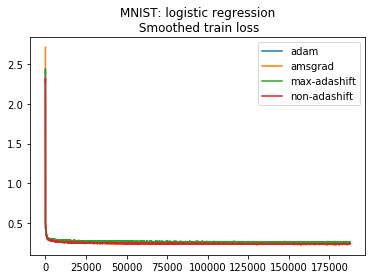

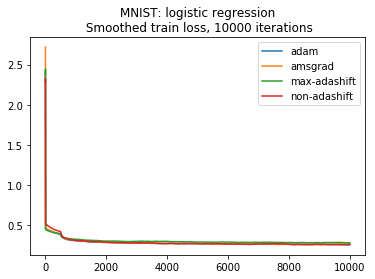

In [131]:
plt.title("MNIST: logistic regression\n Smoothed train loss")
plt.plot(smooth(adam_train_loss_hist, smooth_size, smooth_start_train_loss), label="adam")
plt.plot(smooth(amsgrad_train_loss_hist, smooth_size, smooth_start_train_loss), label="amsgrad")
plt.plot(smooth(adashift_train_loss_hist, smooth_size, smooth_start_train_loss), label="max-adashift")
plt.plot(smooth(non_adashift_train_loss_hist, smooth_size, smooth_start_train_loss), label="non-adashift")

plt.legend(loc='best')
plt.show()

plt.title("MNIST: logistic regression\n Smoothed train loss, 10000 iterations")

plt.plot(smooth(adam_train_loss_hist[:10000], smooth_size, smooth_start_train_loss), label="adam")
plt.plot(smooth(amsgrad_train_loss_hist[:10000], smooth_size, smooth_start_train_loss), label="amsgrad")
plt.plot(smooth(adashift_train_loss_hist[:10000], smooth_size, smooth_start_train_loss), label="max-adashift")
plt.plot(smooth(non_adashift_train_loss_hist[:10000], smooth_size, smooth_start_train_loss), label="non-adashift")

plt.legend(loc='best')
plt.show()

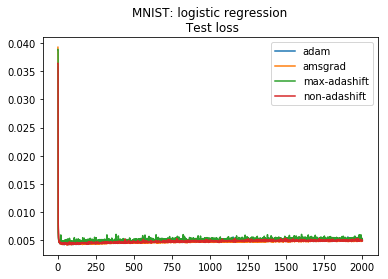

In [139]:
plt.title("MNIST: logistic regression\n Test loss")
plt.plot(adam_test_loss_hist, label="adam")
plt.plot(amsgrad_test_loss_hist, label="amsgrad")
plt.plot(adashift_test_loss_hist, label="max-adashift")
plt.plot(non_adashift_test_loss_hist, label="non-adashift")

plt.legend(loc='best')
plt.show()

### MLP

In [271]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [272]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.fc3 = nn.Linear(hidden_size, num_classes) 
        
        with torch.no_grad():
            for p in self.parameters():
                p.data = torch.tensor(np.random.randn(*p.shape).astype(np.float32))
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
#         return F.log_softmax(out, dim=1)
        return out

In [273]:
hidden_size = 256
criterion = nn.CrossEntropyLoss()

In [274]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0)

adam_train_loss_hist_mlp, adam_test_loss_hist_mlp, adam_test_acc_hist_mlp = \
                            train(model, device, train_loader, adam_optimizer, 60, criterion)                

Train Epoch: 0 TrainLoss: 12424.843750
Test set:       TestLoss:  191.2777, Accuracy: 10%
Train Epoch: 1 TrainLoss: 539.003906
Test set:       TestLoss:  5.2991, Accuracy: 87%
Train Epoch: 2 TrainLoss: 165.095688
Test set:       TestLoss:  3.7273, Accuracy: 88%
Train Epoch: 3 TrainLoss: 426.265015
Test set:       TestLoss:  3.0777, Accuracy: 88%
Train Epoch: 4 TrainLoss: 81.640556
Test set:       TestLoss:  2.7030, Accuracy: 89%
Train Epoch: 5 TrainLoss: 150.768784
Test set:       TestLoss:  2.2783, Accuracy: 88%
Train Epoch: 6 TrainLoss: 337.054932
Test set:       TestLoss:  1.9530, Accuracy: 89%
Train Epoch: 7 TrainLoss: 104.460800
Test set:       TestLoss:  1.7858, Accuracy: 89%
Train Epoch: 8 TrainLoss: 83.189224
Test set:       TestLoss:  1.9429, Accuracy: 87%
Train Epoch: 9 TrainLoss: 155.611588
Test set:       TestLoss:  1.6610, Accuracy: 88%
Train Epoch: 10 TrainLoss: 72.841202
Test set:       TestLoss:  1.3389, Accuracy: 90%
Train Epoch: 11 TrainLoss: 126.494156
Test set:     

In [275]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

amsgrad_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0,amsgrad=True)

amsgrad_train_loss_hist_mlp, amsgrad_test_loss_hist_mlp, amsgrad_test_acc_hist_mlp = \
                            train(model, device, train_loader, amsgrad_optimizer, 60, criterion)               

Train Epoch: 0 TrainLoss: 10241.182617
Test set:       TestLoss:  156.9809, Accuracy: 9%
Train Epoch: 1 TrainLoss: 115.530479
Test set:       TestLoss:  5.3798, Accuracy: 87%
Train Epoch: 2 TrainLoss: 291.581116
Test set:       TestLoss:  3.6861, Accuracy: 88%
Train Epoch: 3 TrainLoss: 578.905884
Test set:       TestLoss:  3.1834, Accuracy: 88%
Train Epoch: 4 TrainLoss: 67.416565
Test set:       TestLoss:  2.5243, Accuracy: 89%
Train Epoch: 5 TrainLoss: 163.977081
Test set:       TestLoss:  2.2995, Accuracy: 89%
Train Epoch: 6 TrainLoss: 71.726234
Test set:       TestLoss:  2.6283, Accuracy: 86%
Train Epoch: 7 TrainLoss: 192.083374
Test set:       TestLoss:  1.7464, Accuracy: 89%
Train Epoch: 8 TrainLoss: 62.794949
Test set:       TestLoss:  1.6688, Accuracy: 88%
Train Epoch: 9 TrainLoss: 25.134111
Test set:       TestLoss:  1.6078, Accuracy: 88%
Train Epoch: 10 TrainLoss: 46.031754
Test set:       TestLoss:  1.3926, Accuracy: 89%
Train Epoch: 11 TrainLoss: 27.597561
Test set:       Te

In [ ]:
from adashift.optimizers import AdaShift

In [277]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

adashift_optimizer = AdaShift(model.parameters(), lr=1e-2,\
                             betas=(0.0, 0.999), eps=1e-8)

adashift_train_loss_hist_mlp, adashift_test_loss_hist_mlp, adashift_test_acc_hist_mlp = \
                            train(model, device, train_loader, adashift_optimizer, 60, criterion) 

Train Epoch: 0 TrainLoss: 10391.145508
Test set:       TestLoss:  184.7383, Accuracy: 10%
Train Epoch: 1 TrainLoss: 317.942200
Test set:       TestLoss:  4.8458, Accuracy: 87%
Train Epoch: 2 TrainLoss: 369.249847
Test set:       TestLoss:  3.6788, Accuracy: 87%
Train Epoch: 3 TrainLoss: 118.557365
Test set:       TestLoss:  3.0060, Accuracy: 88%
Train Epoch: 4 TrainLoss: 178.613068
Test set:       TestLoss:  2.6569, Accuracy: 88%
Train Epoch: 5 TrainLoss: 180.843597
Test set:       TestLoss:  2.0740, Accuracy: 89%
Train Epoch: 6 TrainLoss: 173.098267
Test set:       TestLoss:  2.1496, Accuracy: 87%
Train Epoch: 7 TrainLoss: 66.743835
Test set:       TestLoss:  1.9086, Accuracy: 87%
Train Epoch: 8 TrainLoss: 88.382362
Test set:       TestLoss:  1.5682, Accuracy: 88%
Train Epoch: 9 TrainLoss: 57.763279
Test set:       TestLoss:  1.5917, Accuracy: 88%
Train Epoch: 10 TrainLoss: 41.415504
Test set:       TestLoss:  1.4083, Accuracy: 89%
Train Epoch: 11 TrainLoss: 125.757751
Test set:      

In [278]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

amsgrad_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0,amsgrad=True)

amsgrad_train_loss_hist_mlp, amsgrad_test_loss_hist_mlp, amsgrad_test_acc_hist_mlp =\
        train(model, device, train_loader, amsgrad_optimizer, 60, criterion)               

Train Epoch: 0 TrainLoss: 8018.006836
Test set:       TestLoss:  149.7959, Accuracy: 14%
Train Epoch: 1 TrainLoss: 333.802216
Test set:       TestLoss:  5.3020, Accuracy: 87%
Train Epoch: 2 TrainLoss: 249.750305
Test set:       TestLoss:  3.7208, Accuracy: 88%
Train Epoch: 3 TrainLoss: 150.958191
Test set:       TestLoss:  2.9438, Accuracy: 89%
Train Epoch: 4 TrainLoss: 65.323204
Test set:       TestLoss:  2.4267, Accuracy: 89%
Train Epoch: 5 TrainLoss: 234.392227
Test set:       TestLoss:  2.0885, Accuracy: 89%
Train Epoch: 6 TrainLoss: 26.474272
Test set:       TestLoss:  1.8603, Accuracy: 90%
Train Epoch: 7 TrainLoss: 25.999496
Test set:       TestLoss:  1.6736, Accuracy: 90%
Train Epoch: 8 TrainLoss: 58.063782
Test set:       TestLoss:  1.4741, Accuracy: 89%
Train Epoch: 9 TrainLoss: 26.192036
Test set:       TestLoss:  1.4074, Accuracy: 89%
Train Epoch: 10 TrainLoss: 46.384991
Test set:       TestLoss:  1.4510, Accuracy: 88%
Train Epoch: 11 TrainLoss: 78.602516
Test set:       Tes

([8018.0068359375,
  10218.2099609375,
  7963.56298828125,
  8576.9931640625,
  9162.6611328125,
  8055.0361328125,
  6432.19580078125,
  6746.86328125,
  6200.93017578125,
  6897.4443359375,
  5229.1240234375,
  5402.0068359375,
  5946.48388671875,
  4986.66015625,
  5568.74462890625,
  5121.11669921875,
  6160.71923828125,
  4214.11376953125,
  5435.6767578125,
  4505.31884765625,
  4986.07177734375,
  4212.8359375,
  3628.252197265625,
  4608.8447265625,
  5095.4736328125,
  2735.199951171875,
  2992.4296875,
  3626.9267578125,
  4216.82080078125,
  3465.105224609375,
  3678.895263671875,
  3363.6640625,
  4184.05517578125,
  3024.45068359375,
  2533.691650390625,
  2866.9306640625,
  2562.7958984375,
  2292.0361328125,
  3023.803955078125,
  2694.528076171875,
  2553.771240234375,
  3211.002685546875,
  2625.4345703125,
  1889.3033447265625,
  1976.980712890625,
  2232.70263671875,
  2277.39453125,
  2889.8173828125,
  1763.6619873046875,
  2010.9952392578125,
  2062.217529296875,


In [279]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

non_adashift_optimizer = AdaShift(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, reduce_func=lambda x: x)

non_adashift_train_loss_hist_mlp, non_adashift_test_loss_hist_mlp, non_adashift_test_acc_hist_mlp = \
                            train(model, device, train_loader, non_adashift_optimizer, 60, criterion) 

Train Epoch: 0 TrainLoss: 10050.528320
Test set:       TestLoss:  159.8972, Accuracy: 7%
Train Epoch: 1 TrainLoss: 1306.182861
Test set:       TestLoss:  13.9421, Accuracy: 86%
Train Epoch: 2 TrainLoss: 851.853699
Test set:       TestLoss:  8.4993, Accuracy: 88%
Train Epoch: 3 TrainLoss: 514.968323
Test set:       TestLoss:  7.5071, Accuracy: 87%
Train Epoch: 4 TrainLoss: 58.890961
Test set:       TestLoss:  6.2026, Accuracy: 88%
Train Epoch: 5 TrainLoss: 506.122864
Test set:       TestLoss:  6.2520, Accuracy: 87%
Train Epoch: 6 TrainLoss: 1004.809448
Test set:       TestLoss:  10.8496, Accuracy: 82%
Train Epoch: 7 TrainLoss: 129.233093
Test set:       TestLoss:  5.2543, Accuracy: 89%
Train Epoch: 8 TrainLoss: 354.715027
Test set:       TestLoss:  5.0659, Accuracy: 88%
Train Epoch: 9 TrainLoss: 106.430542
Test set:       TestLoss:  5.6624, Accuracy: 87%
Train Epoch: 10 TrainLoss: 310.529480
Test set:       TestLoss:  5.9653, Accuracy: 88%
Train Epoch: 11 TrainLoss: 688.843689
Test set:

In [288]:
adam_train_loss_hist_mlp = save_as_npy('adam_train_loss_hist_mlp', adam_train_loss_hist_mlp)
amsgrad_train_loss_hist_mlp = save_as_npy('amsgrad_train_loss_hist_mlp', amsgrad_train_loss_hist_mlp)
adashift_train_loss_hist_mlp = save_as_npy('adashift_train_loss_hist_mlp', adashift_train_loss_hist_mlp)
non_adashift_train_loss_hist_mlp = save_as_npy('non_adashift_train_loss_hist_mlp', non_adashift_train_loss_hist_mlp)

adam_test_loss_hist_mlp = save_as_npy('adam_test_loss_hist_mlp', adam_test_loss_hist_mlp)
amsgrad_test_loss_hist_mlp = save_as_npy('amsgrad_test_loss_hist_mlp', amsgrad_test_loss_hist_mlp)
adashift_test_loss_hist_mlp = save_as_npy('adashift_test_loss_hist_mlp', adashift_test_loss_hist_mlp)
non_adashift_test_loss_hist_mlp = save_as_npy('non_adashift_test_loss_hist_mlp', non_adashift_test_loss_hist_mlp)

adam_test_acc_hist_mlp = save_as_npy('adam_test_acc_hist_mlp', adam_test_acc_hist_mlp)
amsgrad_test_acc_hist_mlp = save_as_npy('amsgrad_test_acc_hist_mlp', amsgrad_test_acc_hist_mlp)
adashift_test_acc_hist_mlp = save_as_npy('adashift_test_acc_hist_mlp', adashift_test_acc_hist_mlp)
non_adashift_test_acc_hist_mlp = save_as_npy('non_adashift_test_acc_hist_mlp', non_adashift_test_acc_hist_mlp)

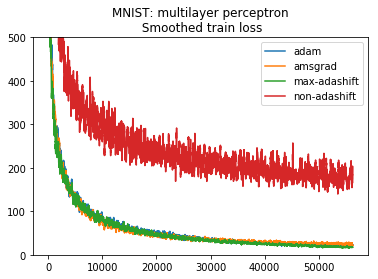

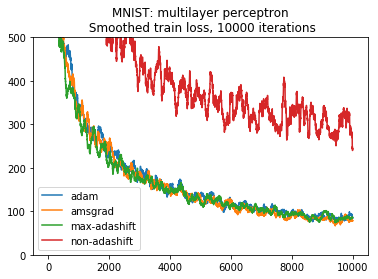

In [292]:
smooth_size = 100
plt.title("MNIST: multilayer perceptron\n Smoothed train loss")
plt.plot(smooth(adam_train_loss_hist_mlp, smooth_size, smooth_start_train_loss), label="adam")
plt.plot(smooth(amsgrad_train_loss_hist_mlp, smooth_size, smooth_start_train_loss), label="amsgrad")
plt.plot(smooth(adashift_train_loss_hist_mlp, smooth_size, smooth_start_train_loss), label="max-adashift")
plt.plot(smooth(non_adashift_train_loss_hist_mlp, smooth_size, smooth_start_train_loss), label="non-adashift")
plt.ylim((0, 500))

plt.legend(loc='best')
plt.show()

plt.title("MNIST: multilayer perceptron\n Smoothed train loss, 10000 iterations")

plt.plot(smooth(adam_train_loss_hist_mlp[:10000], smooth_size, smooth_start_train_loss), label="adam")
plt.plot(smooth(amsgrad_train_loss_hist_mlp[:10000], smooth_size, smooth_start_train_loss), label="amsgrad")
plt.plot(smooth(adashift_train_loss_hist_mlp[:10000], smooth_size, smooth_start_train_loss), label="max-adashift")
plt.plot(smooth(non_adashift_train_loss_hist_mlp[:10000], smooth_size, smooth_start_train_loss), label="non-adashift")
plt.ylim((0, 500))

plt.legend(loc='best')
plt.show()

/home/mkonobeev/miniconda3/envs/mkonobeev/lib/python3.6/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


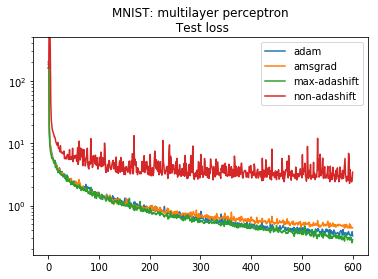

In [294]:
plt.title("MNIST: multilayer perceptron\n Test loss")
plt.semilogy(adam_test_loss_hist_mlp, label="adam")
plt.semilogy(amsgrad_test_loss_hist_mlp, label="amsgrad")
plt.semilogy(adashift_test_loss_hist_mlp, label="max-adashift")
plt.semilogy(non_adashift_test_loss_hist_mlp, label="non-adashift")
plt.ylim((0, 500))

plt.legend(loc='best')
plt.show()

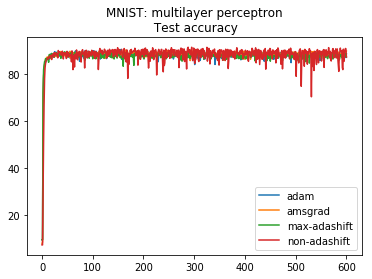

In [295]:
plt.title("MNIST: multilayer perceptron\n Test accuracy")
plt.plot(adam_test_acc_hist_mlp, label="adam")
plt.plot(amsgrad_test_acc_hist_mlp, label="amsgrad")
plt.plot(adashift_test_acc_hist_mlp, label="max-adashift")
plt.plot(non_adashift_test_acc_hist_mlp, label="non-adashift")

plt.legend(loc='best')
plt.show()